## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


## Compute the camera calibration using chessboard images


In [10]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os
import pickle
import matplotlib

%matplotlib inline

In [11]:
def calibration(IMG_PATH, chessboard_shape):
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    # Make a list of calibration images
    images = glob.glob(IMG_PATH)
    
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((chessboard_shape[1] * chessboard_shape[0], 3), np.float32)
    objp[:,:2] = np.mgrid[0:chessboard_shape[0], 0:chessboard_shape[1]].T.reshape(-1,2)
    
    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, chessboard_shape, None)
        
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
        
        # Save images with drawing corners
        new_fname = fname.split('/')[-1]
        img = cv2.drawChessboardCorners(img, chessboard_shape, corners, ret)
        SAVE_PATH = 'output_images/calibration/'
        cv2.imwrite(filename=SAVE_PATH + '/' + new_fname, img=img)
        
    return cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


In [12]:
CAL_IMG_PATH = './camera_cal/calibration*.jpg'
chessboard_shape = (9, 6)

ret, mtx, dist, rvecs, tvecs = calibration(CAL_IMG_PATH, chessboard_shape)
with open('output_images/calibration/calibration.p', 'wb') as file:
    pickle.dump((ret, mtx, dist, rvecs, tvecs), file)


Display all test images

In [632]:
def display_comparison(ori_img, new_img, new_title, fname, gray=False):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    f.tight_layout()
    matplotlib.rc('xtick', labelsize=15) 
    matplotlib.rc('ytick', labelsize=15)
    ax1.imshow(cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image:', fontsize=15)
    if gray:
        ax2.imshow(new_img, cmap='gray')
    else:
        ax2.imshow(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB), cmap='gray')
    ax2.set_title(new_title, fontsize=15)
    f.savefig('output_images/comparison/' + fname)
    plt.show()

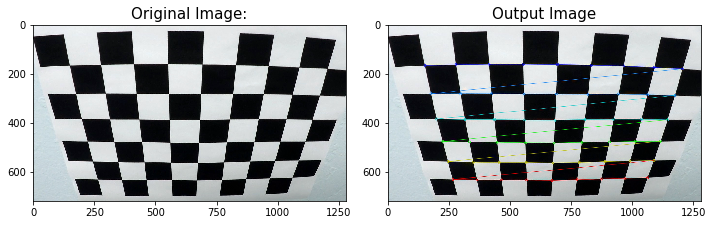

In [14]:
test_chess_img = plt.imread(os.path.join('camera_cal', 'calibration2.jpg'))
cal_img = plt.imread(os.path.join('output_images/calibration/', 'calibration2.jpg'))
display_comparison(test_chess_img, cal_img, 'Output Image', 'chees_out')

## Apply a distortion correction to raw images.

In [15]:
def undistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

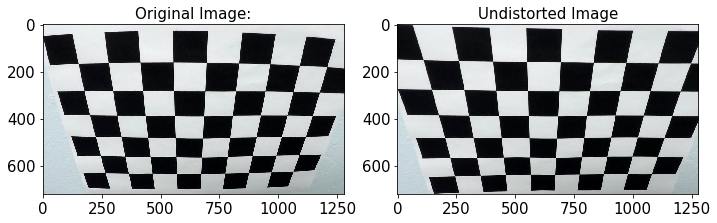

In [16]:
undistorted_chess_img = undistort(test_chess_img, mtx, dist)

display_comparison(test_chess_img, undistorted_chess_img, 'Undistorted Image', 'undistorted_chess')

In [240]:
test_img = cv2.imread('test_images/challenge_test_img.jpg')
test_img = cv2.resize(test_img, (1280, 720))
cv2.imwrite(filename='test_images/challenge_test_img.jpg', img=test_img)

True

In [1782]:
# Make a list of test images
test_images = glob.glob('./test_images/*.jpg')
# ROAD_SAVE_PATH = 'output_images/road/'
UNDISTORTED_SAVE_PATH = 'output_images/undistorted/'
UNDISTORTED_FULL_SAVE_PATH = 'output_images/undistorted/full_image/'

imshape = cv2.imread(test_images[3]).shape

vertices = np.array([[(150, imshape[0]), (570, 430), (700, 430),
                    (imshape[1]-80, imshape[0])]], dtype=np.int32)

undistored_list = []
for fname in test_images:
    img = cv2.imread(fname)
    new_fname = fname.split('/')[-1]
    undist = undistort(img, mtx, dist)
    cv2.imwrite(filename=UNDISTORTED_FULL_SAVE_PATH + '/' + new_fname, img=undist)
#     img = region_of_interest(img, vertices)
#     cv2.imwrite(filename=ROAD_SAVE_PATH + '/' + new_fname, img=img)
    img = undistort(img, mtx, dist)   
    undistored_list.append(img)
    cv2.imwrite(filename=UNDISTORTED_SAVE_PATH + '/' + new_fname, img=img)



Display undistorted image example

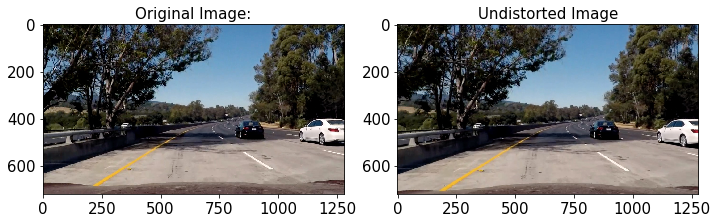

In [1783]:
# test_img = cv2.imread('test_images/challenge_test_img.jpg')
test_img = cv2.imread('test_images/test5.jpg')


undistorted_img = undistort(test_img, mtx, dist)

display_comparison(test_img, undistorted_img, 'Undistorted Image', 'undistorted_img')


## Apply a perspective transform to rectify binary image ("birds-eye view").

In [1784]:
def perspective_transform(img):
    """convert the perspective image to bird view"""   
#     image_shape = img_binary.shape
    image_shape = (img.shape[1], img.shape[0])
    
#     src = np.float32([[258, 679], [446, 549], [837, 549], [1045, 679]]) 
#     dst = np.float32([[258, 679], [258, 549], [837, 549], [837, 679]]) 
    # Source points
    
#     offset = 350 # offset for dst points
#     src = np.float32([[[ 610,  450]], 
#                       [[ 680,  450]], 
#                       [[ image_shape[0]-300,  680]],
#                       [[ 380,  680]]])

#     # Result points        
#     dst = np.float32([[offset, 0], 
#                     [image_shape[0]-offset, 0], 
#                     [image_shape[0]-offset, image_shape[1]], 
#                     [offset, image_shape[1]]])
    
    src = np.float32([[180, img.shape[0]], [575, 460], 
                      [705, 460], [1150, img.shape[0]]])
    # Define 4 destination points
    dst = np.float32([[320, img.shape[0]], [320, 0], 
                      [960, 0], [960, img.shape[0]]])


    image_shape = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    M_T = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, image_shape, flags=cv2.INTER_LINEAR)
    return warped, M, M_T


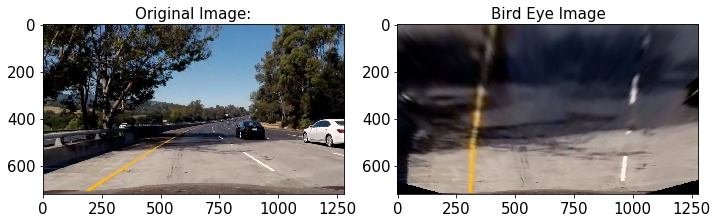

In [1785]:
# warped_img, M, M_T = perspective_transform(threshold_binary_img, src, dst)
warped_img, M, M_T = perspective_transform(undistorted_img)

# warped = cv2.imread('output_images/perspective_transform/challenge_test_img.jpg')
display_comparison(undistorted_img, warped_img, 'Bird Eye Image', 'bird_eye')

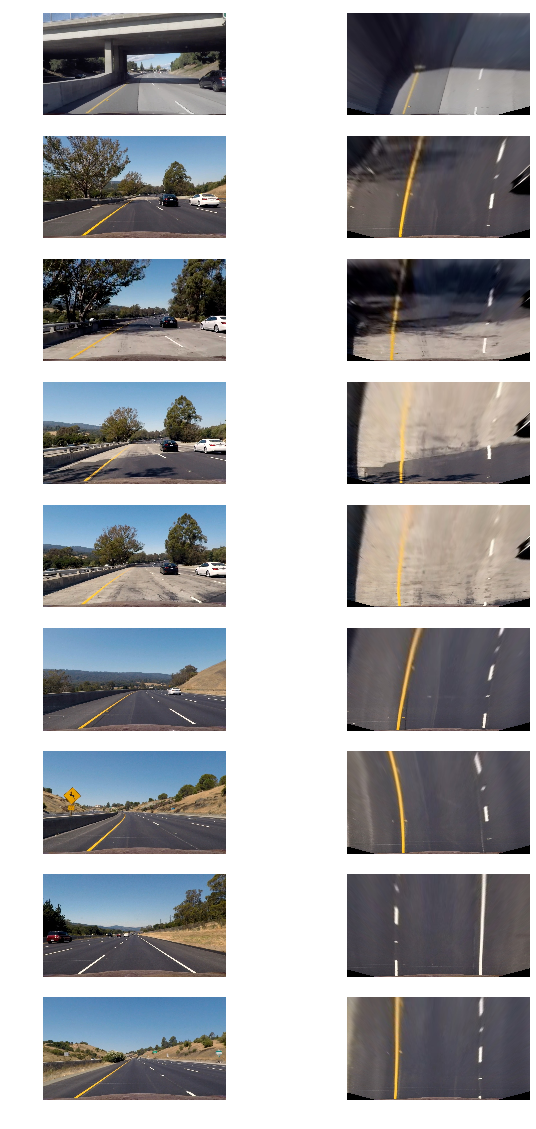

In [1787]:
undistored_images = glob.glob('./output_images/undistorted/*.jpg')

warped_list = []                                          

f, axs = plt.subplots(len(images),2, figsize=(10, 20))
axs = axs.ravel()
i = 0
for image in undistored_images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    output, _, _ = perspective_transform(img)
    warped_list.append(output)
    axs[i].imshow(img)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(output, cmap='gray')
    axs[i].axis('off')
    i += 1
f.savefig('output_images/comparison/' + 'warped_all_images')
plt.show()


## 3. Use color transforms, gradients, etc., to create a thresholded binary image.

In [1788]:
def threshold_binary(img):
    img = np.copy(img) 
    """
    HLS
    """
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    s_thresh=(170, 255)
    sx_thresh=(25, 100)

    
    sobelx =  cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    """UPDATE H channel. NEED NOTICE
        After add H channel, it did't improve the performance.
        The review suggestion, said it remain quite constant with changes in luminosity,
        but I don't know how to add it correctly.
        
    """
    
    """
    LUV
    """
    luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    luv_l_channel = luv[:,:,0]
    
    luv_l_thresh = (225, 255)
    
    luv_l_binary = np.zeros_like(luv_l_channel)
    luv_l_binary[(luv_l_channel >= luv_l_thresh[0]) & (luv_l_channel <= luv_l_thresh[1])] = 1
    
    """
    LAB
    """
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b_channel = lab[:,:,2]
    
    lab_b_thresh = (100, 200)
    
    lab_b_binary = np.zeros_like(lab_b_channel)
    lab_b_binary[(lab_b_channel >= lab_b_thresh[0]) & (lab_b_channel <= lab_b_thresh[1])]
    
#     h_binary = np.zeros_like(h_channel)
#     h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    
    
    combined_binary = np.zeros_like(s_binary)
    combined_binary[ (s_binary == 1) | (sxbinary == 1)|(luv_l_binary == 1) | (lab_b_binary == 1)] = 1
#     combined_binary[(sxbinary == 1)|(s_binary == 1) ] = 1
    
    return combined_binary

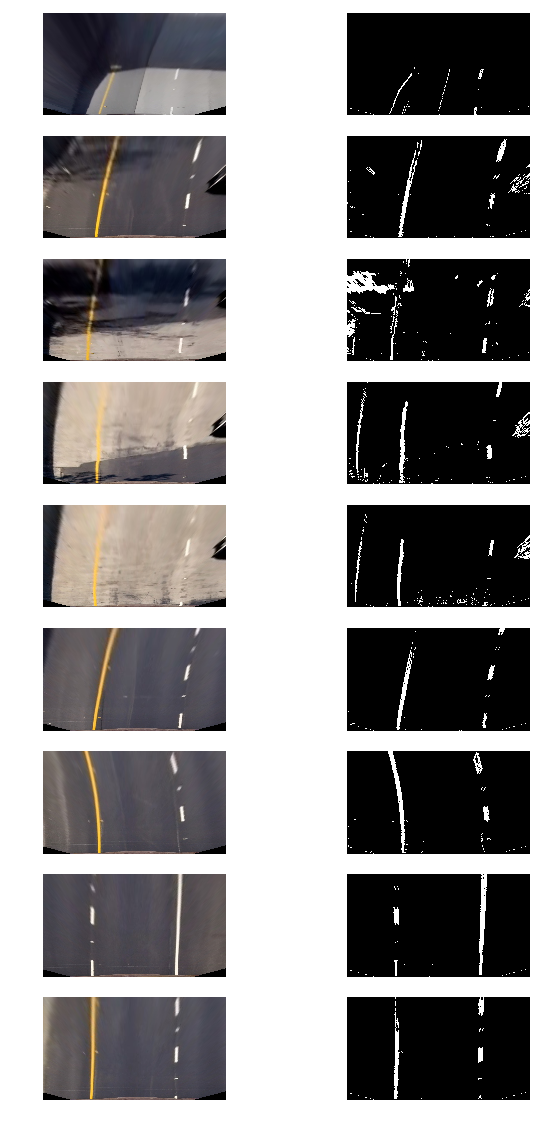

In [1789]:
binary_warped_list = []                                          

f, axs = plt.subplots(len(images),2, figsize=(10, 20))
axs = axs.ravel()
i = 0
for img in warped_list:
#     img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    output = threshold_binary(img)
    binary_warped_list.append(output)
    axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[i].axis('off')
    i += 1
    axs[i].imshow(output, cmap='gray')
    axs[i].axis('off')
    i += 1
f.savefig('output_images/comparison/' + 'binary_warped_images')
plt.show()


Utility function from Project 1, find the region that we are interested.

In [1790]:
# vertices = np.array([[(150, 720), 
#                       (150, 0), 
#                       (1200, 0),
#                       (1200, 720)]], dtype=np.int32)
# vertices = np.array([[(150, 720), 
#                       (150, 0), 
#                       (1200, 0),
#                       (1200, 720)]], dtype=np.int32)

vertices = np.array([[(200, 720), 
                      (150, 0), 
                      (1150, 0),
                      (1100, 720)]], dtype=np.int32)

def region_of_interest(img, vertices=vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    shape = img.shape
    
    
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

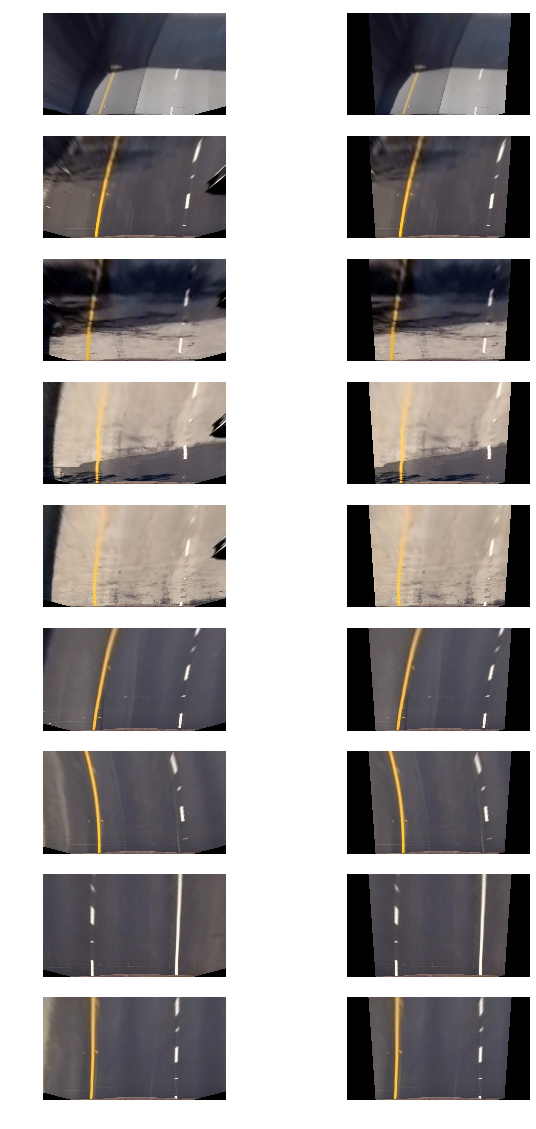

In [1791]:
warped_images = glob.glob('./output_images/perspective_transform/*.jpg')

f, axs = plt.subplots(len(images),2, figsize=(10, 20))
axs = axs.ravel()
i = 0
# for img in binary_warped_list:
for img in warped_list:

    output = region_of_interest(img, vertices)
    region_list.append(output)
    
    axs[i].imshow(img, cmap='gray')
    axs[i].axis('off')
    i += 1
    axs[i].imshow(output, cmap='gray')
    axs[i].axis('off')
    i += 1
f.savefig('output_images/comparison/' + 'region_images')
plt.show()


In [1792]:
def img_pipeline(img):
    # Undistort original image
    undistorted = undistort(img, mtx, dist)
    # Apply a perspective transform to rectify binary image
    warped, M, Minv = perspective_transform(undistorted)
    # Create a thresholded binary image
    binary_thresholded = threshold_binary(warped)

    result = region_of_interest(binary_thresholded)
    
    return result, Minv


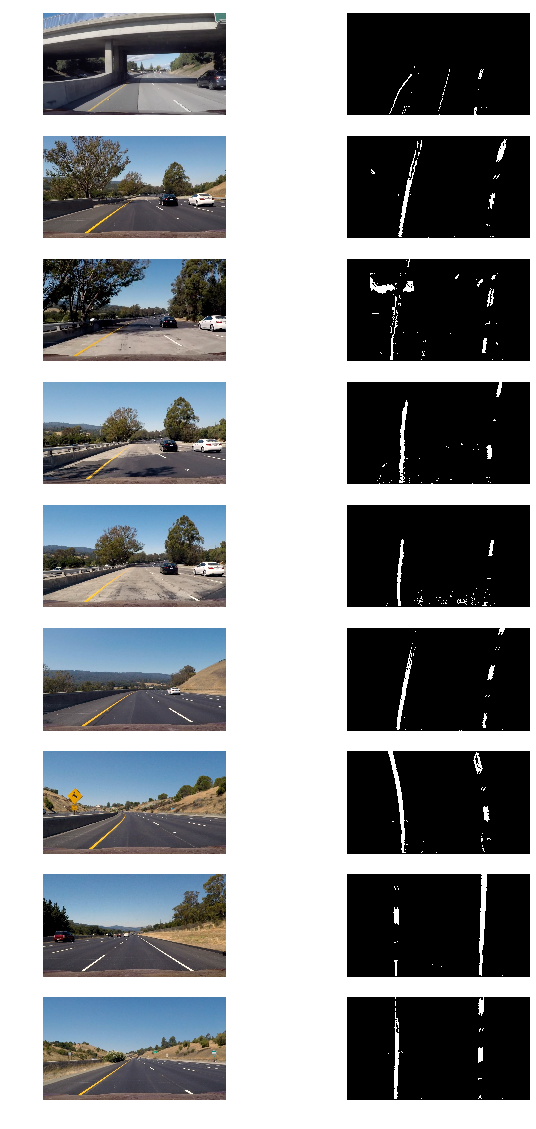

In [1793]:
test_images = glob.glob('./test_images/*.jpg')

pipeline_list = []                                          

f, axs = plt.subplots(len(images),2, figsize=(10, 20))
axs = axs.ravel()
i = 0
for image in test_images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    output, _ = img_pipeline(img)
    pipeline_list.append(output)
    axs[i].imshow(img)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(output, cmap='gray')
    axs[i].axis('off')
    i += 1
# f.savefig('output_images/comparison/' + 'pipline_all_images')
plt.show()


## 5. Detect lane pixels and fit to find the lane boundary.


In [1963]:


def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    
    quarter_point = np.int(midpoint//2)
    
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 12
    # Set the width of the windows +/- margin
    margin = 10
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin   # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low), (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low), (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
#     try:
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
#     except ValueError:
        # Avoids an error if the above is not implemented fully
#         pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )


    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        

    # Generate x and y values for plotting

    ## Visualization ##
    #For Video:
#     LEFT.recent_xfits = [(left_fitx)]
#     LEFT.best_xfit = np.mean(LEFT.recent_xfits, axis=0)
#     RIGHT.recent_xfits = [(right_fitx)]
#     RIGHT.best_xfit = np.mean(RIGHT.recent_xfits, axis=0)
        
#     LEFT.current_fit_coeffs = [(left_fit)]
#     LEFT.best_fit_coeffs = np.mean(LEFT.current_fit_coeffs, axis=0)
#     RIGHT.current_fit_coeffs = [(right_fit)]
#     RIGHT.best_fit_coeffs = np.mean(RIGHT.current_fit_coeffs, axis=0)
    
    LEFT.line_base_position = leftx_current
    RIGHT.line_base_position = rightx_current
    
#     LEFT.allx = leftx
#     LEFT.ally = lefty
#     RIGHT.allx = rightx
#     RIGHT.ally = righty
    

    return out_img, left_fitx, right_fitx, ploty, left_fit, right_fit, leftx, rightx, lefty, righty, leftx_base, rightx_base



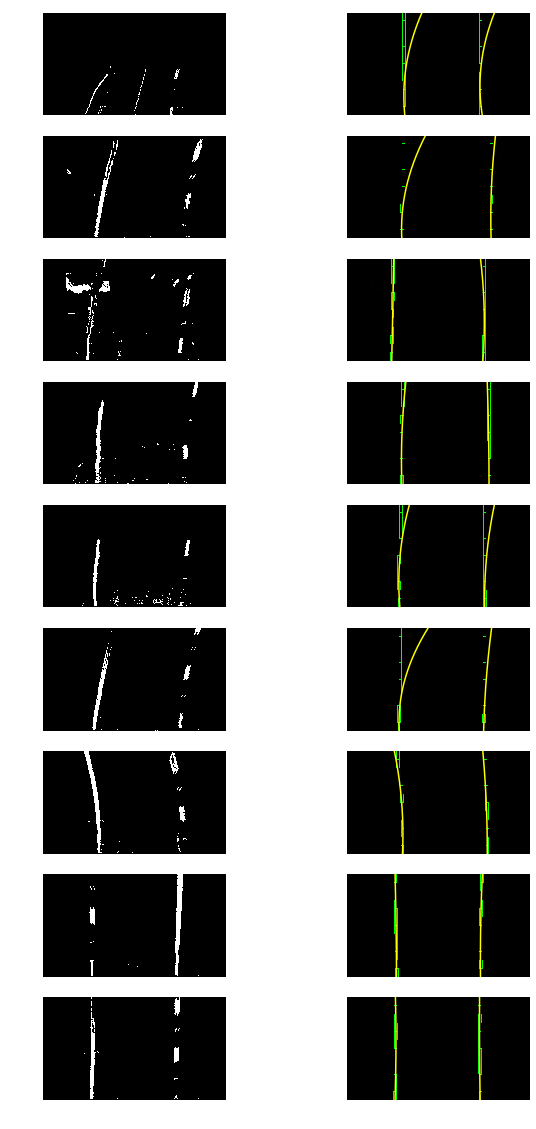

In [1795]:
sliding_list = []                                          

f, axs = plt.subplots(len(images),2, figsize=(10, 20))
axs = axs.ravel()
i = 0
for img in pipeline_list:

    out_img, left_fitx, right_fitx, ploty, left_fit, right_fit, leftx, rightx, lefty, righty, leftx_base, rightx_base = find_lane_pixels(img)
    sliding_list.append(out_img)
    
    axs[i].imshow(img, cmap='gray')
    axs[i].axis('off')
    i += 1
    axs[i].plot(left_fitx, ploty, color='yellow')
    axs[i].plot(right_fitx, ploty, color='yellow')
    axs[i].imshow(out_img, cmap='gray')
    axs[i].axis('off')
    i += 1
f.savefig('output_images/comparison/' + 'sliding_window_all')
plt.show()

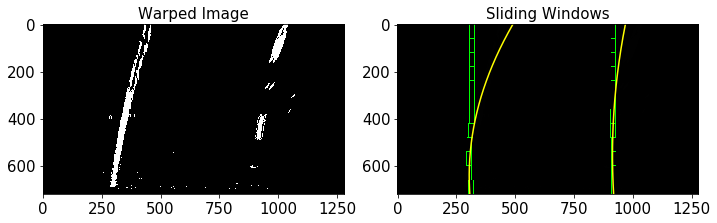

In [1796]:
# warped_img, M, M_T = perspective_transform(threshold_binary_img)


out_img, left_fitx, right_fitx, ploty, left_fit, right_fit, leftx, rightx, lefty, righty, leftx_base, rightx_base = find_lane_pixels(region_list[1])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
f.tight_layout()
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
ax1.imshow(region_list[1], cmap='gray')
ax1.set_title('Warped Image', fontsize=15)

ax2.plot(left_fitx, ploty, color='yellow')
ax2.plot(right_fitx, ploty, color='yellow')
ax2.imshow(out_img, cmap='gray')
ax2.set_title('Sliding Windows', fontsize=15)

f.savefig('output_images/comparison/' + 'sliding')


plt.show()

In [1797]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 10

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Find our lane pixels first
    out_img, left_fitx, right_fitx, ploty, left_fit, right_fit, leftx, rightx, lefty, righty, leftx_base, rightx_base = find_lane_pixels(binary_warped)

#     leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy \
                    + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2)\
                    + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy \
                    + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2)\
                    + right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    

    
#     return result, left_fitx, right_fitx, ploty, left_fit, right_fit
    return result, left_fitx, right_fitx, ploty, left_fit, right_fit, leftx, rightx, lefty, righty



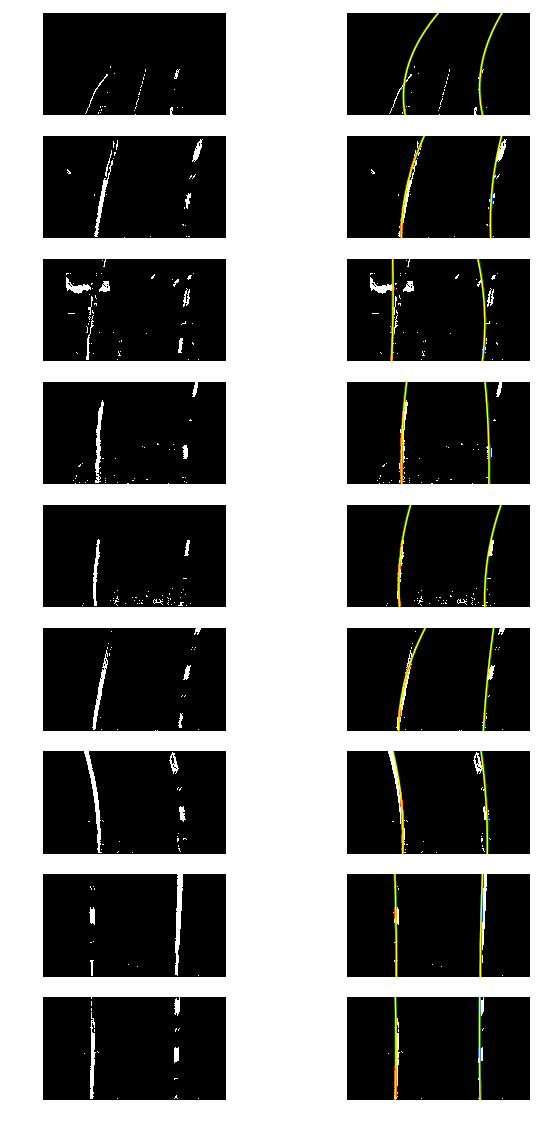

In [1798]:
shaded_list = []                                          

f, axs = plt.subplots(len(images),2, figsize=(10, 20))
axs = axs.ravel()
i = 0
for img in pipeline_list:

    out_img, left_fitx, right_fitx, ploty, left_fit, right_fit, leftx, rightx, lefty, righty = search_around_poly(img)
    shaded_list.append(out_img)
    
    axs[i].imshow(img, cmap='gray')
    axs[i].axis('off')
    i += 1
    axs[i].plot(left_fitx, ploty, color='yellow')
    axs[i].plot(right_fitx, ploty, color='yellow')
    axs[i].imshow(out_img, cmap='gray')
    axs[i].axis('off')
    i += 1
f.savefig('output_images/comparison/' + 'shaded_all')
plt.show()

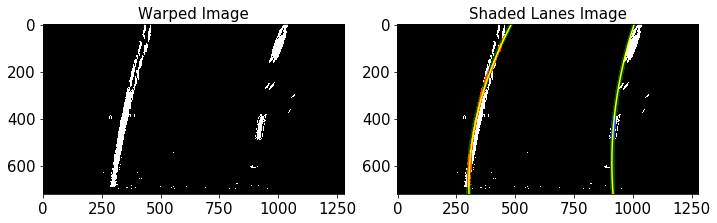

In [2002]:
out_img, left_fitx, right_fitx, ploty, left_fit, right_fit, leftx, rightx, lefty, righty = search_around_poly(region_list[1])
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
f.tight_layout()
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
ax1.imshow(region_list[1], cmap='gray')
ax1.set_title('Warped Image', fontsize=15)

ax2.plot(left_fitx, ploty, color='yellow')
ax2.plot(right_fitx, ploty, color='yellow')
ax2.imshow(out_img, cmap='gray')
ax2.set_title('Shaded Lanes Image', fontsize=15)

f.savefig('output_images/comparison/' + 'shaded_lane')


plt.show()

## 6. Determine the curvature of the lane and vehicle position with respect to center.m

In [1966]:
def measure_curvature_and_offset(image_shape, ploty, left_fit, right_fit, leftx, rightx, lefty, righty, left_fitx, right_fitx):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    
    '''
    UPDATE 
    '''
#     ym_per_pix = 30/720 # meters per pixel in y dimension
#     xm_per_pix = 3.7/700 # meters per pixel in x dimension
    lane_width = right_fitx[-1] - left_fitx[-1]
    xm_per_pix = 3.7 / lane_width
    ym_per_pix = 30 / image_shape[0]

    left = left_fit[0] * y_eval ** 2 + left_fit[1] * y_eval + left_fit[2]
    right = right_fit[0] * y_eval ** 2 + right_fit[1] * y_eval + right_fit[2]
    
    lane_center = (right + left) / 2
#     car_ceneter = image_shape[1] / 2
    car_ceneter = 640

    offset_from_center = np.abs(lane_center - car_ceneter) * xm_per_pix

    '''
    END
    '''    
    left_fit_cr = np.polyfit(ploty * ym_per_pix, left_fitx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty * ym_per_pix, right_fitx * xm_per_pix, 2)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])## Implement the calculation of the left line here
    right_curverad = ((1 +  (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])  ## Implement the calculation of the right line here
    curverad = np.min([left_curverad, right_curverad])
    
    LEFT.line_base_pos = offset_from_center
    RIGHT.line_base_pos = offset_from_center
    LEFT.radius_of_curvature = left_curverad
    RIGHT.radius_of_curvature = right_curverad
    
    return offset_from_center, left_curverad, right_curverad



In [1968]:
out_img, left_fitx, right_fitx, ploty, left_fit, right_fit, leftx, rightx, lefty, righty, leftx_base, rightx_base = find_lane_pixels(pipeline_list[3])

# Calculate the radius of curvature in meters for both lane lines
offset_from_center, left_curverad, right_curverad = measure_curvature_and_offset(out_img.shape, 
                                                            ploty, 
                                                            left_fit, right_fit, 
                                                            leftx, rightx, 
                                                            lefty, righty, 
                                                            left_fitx, right_fitx)

curverad = min(left_curverad, right_curverad)

print("In test2.jpg:")
print('Deviation is {} m'.format(offset_from_center))
print('Radius of curvature is {} m'.format(curverad))


In test2.jpg:
Deviation is 0.2976257104037232 m
Radius of curvature is 1422.420671204666 m


## 7. Warp the detected lane boundaries back onto the original image.

In [1969]:
def drawing(warped, Minv, ploty, left_fitx, right_fitx, src_img):

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (warped.shape[1], warped.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(src_img, 1, newwarp, 0.3, 0)   

    return result


    

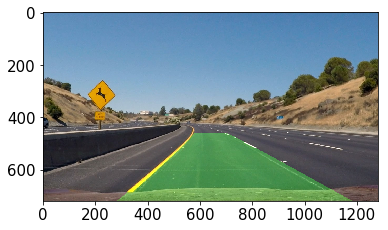

In [1970]:
test_img = cv2.imread('test_images/test2.jpg')
pip_img, _ = img_pipeline(test_img)

out_img, left_fitx, right_fitx, ploty, left_fit, right_fit, leftx, rightx, lefty, righty, leftx_base, rightx_base = find_lane_pixels(pip_img)



drawing_img = drawing(pip_img, 
                      M_T, 
                      ploty, 
                      left_fitx, 
                      right_fitx, 
                      test_img)
    
plt.imshow(cv2.cvtColor(drawing_img, cv2.COLOR_BGR2RGB))
plt.show()

## 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1971]:
def annotate_numbers(image, offset_from_center, curverad):
    font = cv2.FONT_HERSHEY_COMPLEX
    cv2.putText(image, 'Rradius of Curvature = {:.1f}m'.format(curverad), (30, 30),
                font, 1, (255,255,255), 2)
    cv2.putText(image, 'Deviation is {:.1f}m'.format(offset_from_center), (30, 60),
                font, 1, (255,255,255), 2)
    


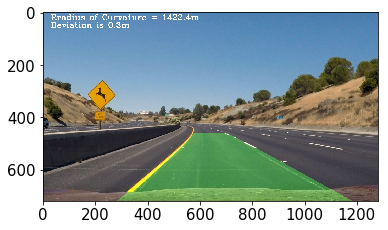

In [1972]:
annotate_numbers(drawing_img, offset_from_center, curverad)

plt.imshow(cv2.cvtColor(drawing_img, cv2.COLOR_BGR2RGB))

plt.savefig('output_images/comparison/' + 'drawing')
plt.show()


In [1973]:
# Define a class to receive the characteristics of each line detection
class Line():
    
    def __init__(self):
        
        self.detected = False
        
        self.recent_xfits = []
        self.best_xfit = None
        
        self.current_fit_coeffs = [np.array([False])]
        self.best_fit_coeffs = None
                
        self.radius_of_curvature = None
        self.line_base_position = None
        
        self.allx = None
        self.ally = None
        
def verify_detection(offset_from_center, L_line_base_position, R_line_base_position):
    lane_width = R_line_base_position - L_line_base_position
#     print(lane_width)
    if np.absolute(offset_from_center) > 1.0 or np.absolute(lane_width) < 500.0 or np.absolute(lane_width) > 700.0:
        return False
    else:
        return True
    

In [1993]:
n_frames = 0

def video_pipeline(img):
    global n_frames
    # For the first frame
    if n_frames == 0:
#         print(n_frames)
        pip_img, Minv = img_pipeline(img)

        # Detect lane pixels and fit to find the lane boundary
        windows_img, left_fitx, right_fitx, ploty, left_fit, right_fit, leftx, rightx, lefty, righty, leftx_base, rightx_base = find_lane_pixels(pip_img)  
        # Determine the curvature of the lane and vehicle position with respect to center.
        offset_from_center, left_curverad, right_curverad = measure_curvature_and_offset(img.shape, 
                                                                    ploty, 
                                                                    left_fit, right_fit, 
                                                                    leftx, rightx, 
                                                                    lefty, righty, 
                                                                    left_fitx, right_fitx)
        curverad = min(left_curverad, right_curverad)
        # Draw shadow on the undistored image
        out_img = drawing(pip_img, 
                          Minv, 
                          ploty, 
                          left_fitx, right_fitx, 
                          img)           
        # Annotate curvature and position on the image
        annotate_numbers(out_img, offset_from_center, curverad)
        n_frames+=1
    else:
        pip_img, Minv = img_pipeline(img)

        if LEFT.detected == True:
            left_fit = LEFT.current_fit_coeffs
        else:
            left_fit = LEFT.best_fit_coeffs
        
        if RIGHT.detected == True:
            right_fit = RIGHT.current_fit_coeffs
        else:
            right_fit = RIGHT.best_fit_coeffs
            
        # Detect lane pixels and fit to find the lane boundary
        windows_img, left_fitx, right_fitx, ploty, left_fit, right_fit, leftx, rightx, lefty, righty, leftx_base, rightx_base = find_lane_pixels(pip_img)

        # Determine the curvature of the lane and vehicle position with respect to center.
        offset_from_center, left_curverad, right_curverad = measure_curvature_and_offset(img.shape, 
                                                                    ploty, 
                                                                    left_fit, right_fit, 
                                                                    leftx, rightx, 
                                                                    lefty, righty, 
                                                                    left_fitx, right_fitx)            
        curverad = min(left_curverad, right_curverad)

        is_lane_width_correct = verify_detection(offset_from_center, 
                                                 LEFT.line_base_position, 
                                                 RIGHT.line_base_position)    


        if is_lane_width_correct == True:
            LEFT.detected = True
            RIGHT.detected = True
        else:
            LEFT.detected = False
            RIGHT.detected = False

        
        if LEFT.detected == True:
            LEFT.recent_xfits.append((left_fitx))
            LEFT.best_xfit = np.mean(LEFT.recent_xfits, axis=0)
            LEFT.current_fit_coeffs.append((left_fit))
            LEFT.best_fit_coeffs = np.mean(LEFT.current_fit_coeffs, axis=0)
            LEFT.allx = leftx
            LEFT.ally = lefty    
        else:
            left_fitx = LEFT.best_xfit
#             left_fitx = LEFT.recent_xfits[-1]
            left_fit = LEFT.best_fit_coeffs
            leftx_current = LEFT.line_base_position
            leftx = LEFT.allx
            lefty = LEFT.ally   
        if RIGHT.detected == True:
            RIGHT.recent_xfits.append((right_fitx))
            RIGHT.best_xfit = np.mean(RIGHT.recent_xfits, axis=0)
            RIGHT.current_fit_coeffs.append((right_fit))
            RIGHT.best_fit_coeffs = np.mean(RIGHT.current_fit_coeffs, axis=0)
            RIGHT.allx = rightx
            RIGHT.ally = righty   
        else:
            right_fitx = RIGHT.best_xfit
#             right_fitx = RIGHT.recent_xfits[-1]
            right_fit = RIGHT.best_fit_coeffs
            rightx = RIGHT.allx
            righty = RIGHT.ally


        offset_from_center, left_curverad, right_curverad = measure_curvature_and_offset(img.shape, 
                                                                    ploty, 
                                                                    left_fit, right_fit, 
                                                                    leftx, rightx, 
                                                                    lefty, righty, 
                                                                    left_fitx, right_fitx)            
        curverad = min(left_curverad, right_curverad)

        # Draw shadow on the undistored image
        out_img = drawing(pip_img, 
                          Minv, 
                          ploty, 
                          left_fitx, right_fitx, 
                          img)  


        annotate_numbers(out_img, offset_from_center, curverad)
        

        
    return out_img

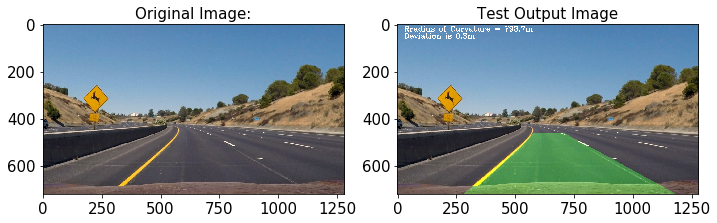

In [1985]:
test_img = cv2.imread('test_images/test2.jpg')
out_img = video_pipeline(test_img)

display(test_img, out_img, 'Test Output Image', 'video_test')

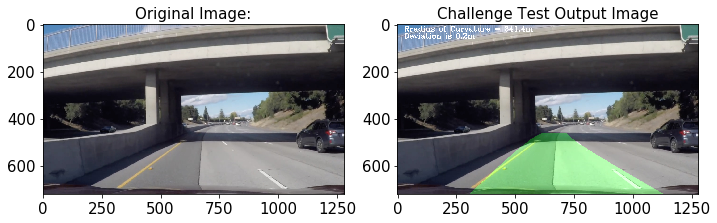

In [1986]:
LEFT = Line()
RIGHT = Line()
n_frames = 1


cha_test_img = cv2.imread('test_images/challenge_test_img.jpg')
out_img = video_pipeline(cha_test_img)


display(cha_test_img, out_img, 'Challenge Test Output Image', 'video_test_cha')

### Run the pipeline on the project video and challenge video



In [1998]:
from moviepy.editor import VideoFileClip
n_frames = 0
video_output = 'video_output/project_video_output.mp4'

# clip = VideoFileClip('project_video.mp4').subclip(24, 31)
clip = VideoFileClip('project_video.mp4')

output_clip = clip.fl_image(video_pipeline)
%time output_clip.write_videofile(video_output, audio=False, verbose=False, progress_bar=False)


CPU times: user 12min 5s, sys: 59 s, total: 13min 4s
Wall time: 2min 6s


In [1999]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

In [1995]:
challenge_video_output = 'video_output/challenge_video_output.mp4'
challenge_clip = VideoFileClip('challenge_video.mp4')

challenge_output_clip = challenge_clip.fl_image(video_pipeline)
%time challenge_output_clip.write_videofile(challenge_video_output, audio=False, verbose=False, progress_bar=False)


CPU times: user 5min 39s, sys: 28.8 s, total: 6min 8s
Wall time: 1min 9s


In [1996]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_video_output))

In [1994]:
harder_challenge_video_output = 'video_output/harder_challenge_video_output.mp4'
harder_challenge_clip = VideoFileClip('harder_challenge_video.mp4')

harder_challenge_output_clip = harder_challenge_clip.fl_image(video_pipeline)
%time harder_challenge_output_clip.write_videofile(harder_challenge_video_output, audio=False, verbose=False, progress_bar=False)


CPU times: user 10min 35s, sys: 44.3 s, total: 11min 19s
Wall time: 1min 56s


In [1997]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(harder_challenge_video_output))